# SNN-CNN-Univariate-Sigma-Delta-Network-SDNN-LAVA

In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import lava
import lava.lib.dl.slayer as slayer
#import lava.lib.dl.decolle 
#from pilotnet_dataset import PilotNetDataset
import utils
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

In [20]:
#data = read_csv('jordan_pv.csv', parse_dates=['date'],  index_col='date')
data = read_csv('Palestine-PV.csv', parse_dates=['date'],  index_col='date')
# Convert index to datetime
data.index = pd.to_datetime(data.index)
# Sort the DataFrame by the index (date) in ascending order to ensure oldest to newest
data = data.sort_index()
# Now select the first column after the index
data = data.iloc[:, 5] 

print(data.shape)
# summarize first 5 rows
#print(data.head(7))
#print(data.tail(7))
#print(data.describe().T)  
print(data.isnull().sum())
data.info()
#plt.plot(data)
data = data[~np.isnan(data)]
data = data.dropna()
data = data.astype('float64')
# Convert the Series to a numpy array and reshape
data= np.array(data).reshape(-1, 1)
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
train_size = int(len(data) * 0.80)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]

#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) 
#and Y is the number of passengers at the next time (t + 1).

def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
seq_size =3 # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.
train_X, train_y = to_sequences(train, seq_size)
test_X, test_y = to_sequences(test, seq_size)
print(train_X.shape, train_y.shape, test_X.shape, test_y .shape)
print(train_X)

# Convert data and labels to PyTorch tensors
train_X=torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X=torch.Tensor(test_X)
test_y = torch.Tensor(test_y)

# Reshape for Conv3d
train_X = train_X.reshape((train_X.shape[0],train_X.shape[1], 1,1,1))
test_X = test_X.reshape((test_X.shape[0],test_X.shape[1], 1,1 ,1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

def event_rate_loss(x, max_rate=0.01):
    mean_event_rate = torch.mean(torch.abs(x))
    return F.mse_loss(F.relu(mean_event_rate - max_rate), torch.zeros_like(mean_event_rate))
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
         # Flag to track sparsity printing
        self.printed_sparsity = False
        sdnn_params = { # sigma-delta neuron parameters
                'threshold'     : 0.05,    # delta unit threshold
                'tau_grad'      : 0.05,    # delta unit surrogate gradient relaxation parameter
                'scale_grad'    : 1,      # delta unit surrogate gradient scale parameter
                'requires_grad' : True,   # trainable threshold
                'shared_param'  : True,   # layer wise threshold
                'activation'    : F.relu, # activation function
            }
        sdnn_cnn_params = { # conv layer has additional mean only batch norm
                **sdnn_params,                                 # copy all sdnn_params
                'norm' : slayer.neuron.norm.MeanOnlyBatchNorm, # mean only quantized batch normalizaton
            }
        sdnn_dense_params = { # dense layers have additional dropout units enabled
                **sdnn_cnn_params,                        # copy all sdnn_cnn_params
                'dropout' : slayer.neuron.Dropout(p=0.05), # neuron dropout
            }
           
        self.blocks = torch.nn.ModuleList([
            #torch.nn.Conv3d(in_channels=3, out_channels=32, kernel_size=1),
           # delta encoding of the input
            slayer.block.sigma_delta.Input(sdnn_cnn_params),
            # convolution layers
            slayer.block.sigma_delta.Conv(sdnn_cnn_params,3 ,32, kernel_size=1),# weight_scale=2, weight_norm=True),
            slayer.block.sigma_delta.Conv(sdnn_cnn_params,32, 32, kernel_size=1),# weight_scale=2, weight_norm=True),
            
          # flatten layer
            slayer.block.sigma_delta.Flatten(),
            
            # dense layers
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32,32),# weight_scale=2, weight_norm=True),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32,32), #weight_scale=2, weight_norm=True),
            # linear readout with sigma decoding of output
            slayer.block.sigma_delta.Output(sdnn_dense_params,32, 1),# weight_scale=2, weight_norm=True)
        ])
        self.sparsity_tracker = {i: [] for i in range(len(self.blocks))}
    def forward(self, x):
        count = []
        event_cost = 0
        sparsity_list = []  # Initialize the sparsity list here

        for i, block in enumerate(self.blocks):
            # forward computation is as simple as calling the blocks in a loop
            x = block(x)
            #print("Input shape:", x.shape)
            if hasattr(block, 'neuron'):
                event_cost += event_rate_loss(x)
                # Masked tensor where elements of x that are greater than 0 are preserved,
                # and others are set to 0
                #masked_x = torch.where(x[..., 1:] > 0, x[..., 1:], torch.zeros_like(x[..., 1:]))
                masked_x = torch.where(x > 0, x, torch.zeros_like(x))

                # Compute the sum of absolute values of this new tensor
                count.append(torch.sum(torch.abs(masked_x)).item())
                
        return x, event_cost, torch.FloatTensor(count).reshape((1, -1)).to(x.device)
    def grad_flow(self, path):
        # helps monitor the gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]
        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()

        return grad
    
    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))
batch  =64# batch size
lr     = 0.001# leaerning rate
lam    = 0.01  # lagrangian for event rate loss
epochs =60  # training epochs
steps  = [60, 120, 160] # learning rate reduction milestones
#steps  = [10, 20, 30,40,50,60] # learning rate reduction milestones
trained_folder = 'Trained'
logs_folder = 'Logs'

os.makedirs(trained_folder, exist_ok=True)
os.makedirs(logs_folder   , exist_ok=True)

#device = torch.device('cuda')
device = torch.device('cpu')
# Instantiate Network, Optimizer, Dataset, and Dataloader
net = Network().to(device)
optimizer = torch.optim.RAdam(net.parameters(), lr=lr, weight_decay=1e-5) #CONV and Dense

training_set = torch.utils.data.TensorDataset(train_X, train_y)
testing_set = torch.utils.data.TensorDataset(test_X, test_y)

train_loader = torch.utils.data.DataLoader(dataset=training_set, batch_size=batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testing_set, batch_size=batch, shuffle=False)

stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(
    net=net,
    error=lambda output  , target: F.mse_loss(output.flatten(), target.flatten()),
    optimizer=optimizer,
    stats=stats,
    count_log=True,
    lam=lam,
    #classifier=slayer.classifier.Rate.predict
)
# Train loop 

for epoch in range(epochs):
    #if epoch in steps:
        #for param_group in optimizer.param_groups:    
          #  print('\nLearning rate reduction from', param_group['lr'])
          #  param_group['lr'] /= 10/3
        
    for i, (input, ground_truth) in enumerate(train_loader): # training loop
        
        assistant.train(input, ground_truth)
        print(f'\r[Epoch {epoch:3d}/{epochs}] {stats}', end='')
    
    for i, (input, ground_truth) in enumerate(test_loader): # testing loop
        
        assistant.test(input, ground_truth)
        print(f'\r[Epoch {epoch:3d}/{epochs}] {stats}', end='')
        
    if epoch%50==49: print() 
    if stats.testing.min_loss:  
        torch.save(net.state_dict(), trained_folder + '/network.pt')
    stats.update()
    stats.save(trained_folder + '/')
    
    # gradient flow monitoring
    net.grad_flow(trained_folder + '/')
    
    # checkpoint saves
    if epoch%10 == 0:
        torch.save({'net': net.state_dict(), 'optimizer': optimizer.state_dict()}, logs_folder + f'/checkpoint{epoch}.pt')            
 

(26280,)
0
<class 'pandas.core.series.Series'>
DatetimeIndex: 26280 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Series name: Solar Radiation(GHI)
Non-Null Count  Dtype  
--------------  -----  
26280 non-null  float64
dtypes: float64(1)
memory usage: 410.6 KB
(21020, 3) (21020,) (5252, 3) (5252,)
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
torch.Size([21020, 3, 1, 1, 1]) torch.Size([21020]) torch.Size([5252, 3, 1, 1, 1]) torch.Size([5252])
[Epoch  49/60] Train loss =     0.00637 (min =     0.00617)     accuracy = 0.00000 (max = 0.00000)  | Test  loss =     0.00328 (min =     0.00315)     accuracy = 0.00000 (max = 0.00000) 
[Epoch  59/60] Train loss =     0.00637 (min =     0.00612)     accuracy = 0.00000 (max = 0.00000)  | Test  loss =     0.00318 (min =     0.00314)     accuracy = 0.00000 (max = 0.00000) 

#  Evaluation: Calculate and Print Unnormalized RMSE and MAE for Testing Set

Test RMSE (Unnormalized): 59.3503
Test MAE (Unnormalized): 28.2635


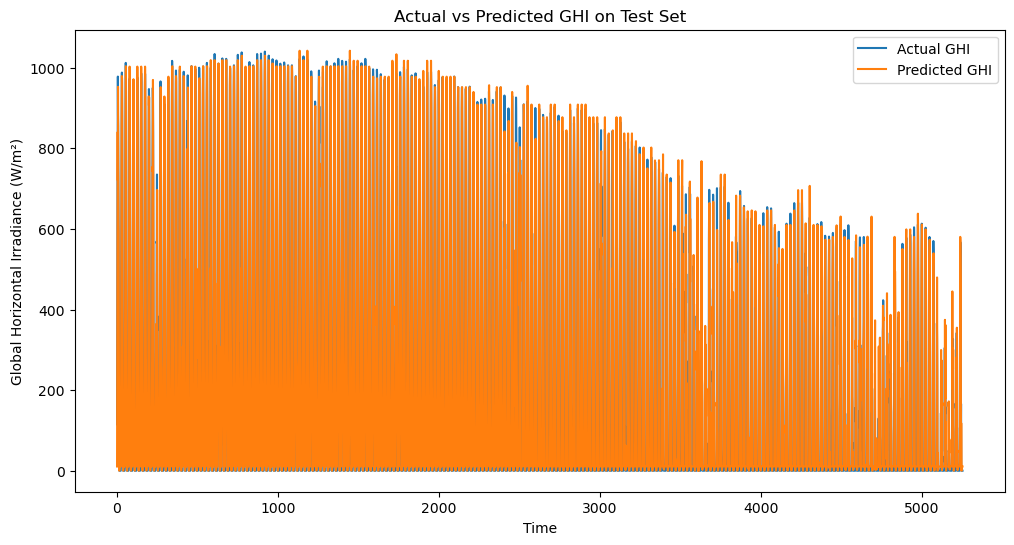

In [21]:
# Evaluation: Calculate and Print Unnormalized RMSE and MAE for Testing Set
# Ensure the model is in evaluation mode
net.eval()

# Make predictions on the test set
with torch.no_grad():
    test_predictions, _, _ = net(test_X.to(device))
    test_predictions = test_predictions.cpu().numpy()

# Inverse transform the predictions and actual values
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_y_inv = scaler.inverse_transform(test_y.numpy().reshape(-1, 1))

# Calculate RMSE and MAE
test_rmse = np.sqrt(mean_squared_error(test_y_inv, test_predictions_inv))
test_mae = mean_absolute_error(test_y_inv, test_predictions_inv)

print(f"Test RMSE (Unnormalized): {test_rmse:.4f}")
print(f"Test MAE (Unnormalized): {test_mae:.4f}")

# Optionally, plot the predictions vs actual values
plt.figure(figsize=(12,6))
plt.plot(test_y_inv, label='Actual GHI')
plt.plot(test_predictions_inv, label='Predicted GHI')
plt.xlabel('Time')
plt.ylabel('Global Horizontal Irradiance (W/m²)')
plt.title('Actual vs Predicted GHI on Test Set')
plt.legend()
plt.show()

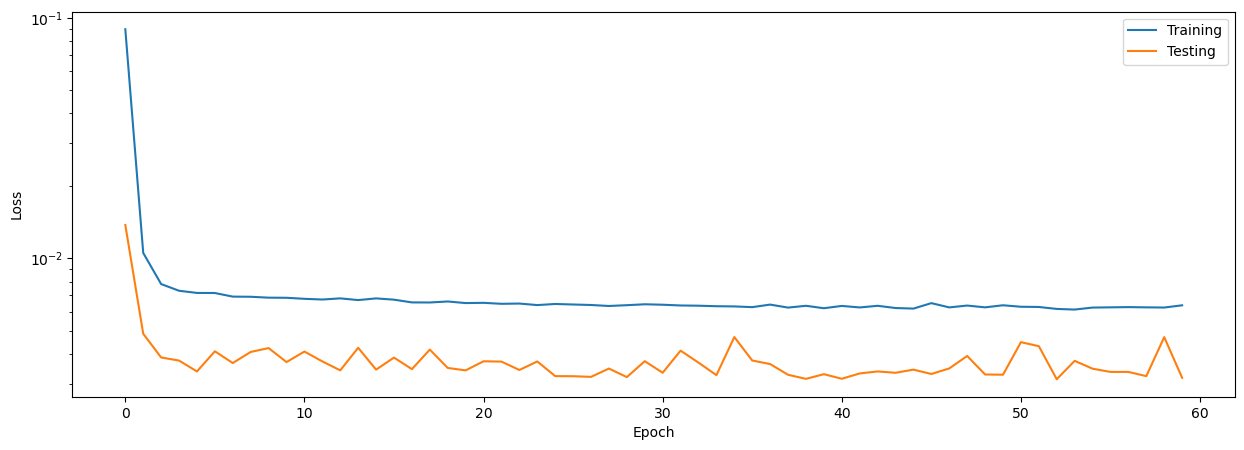

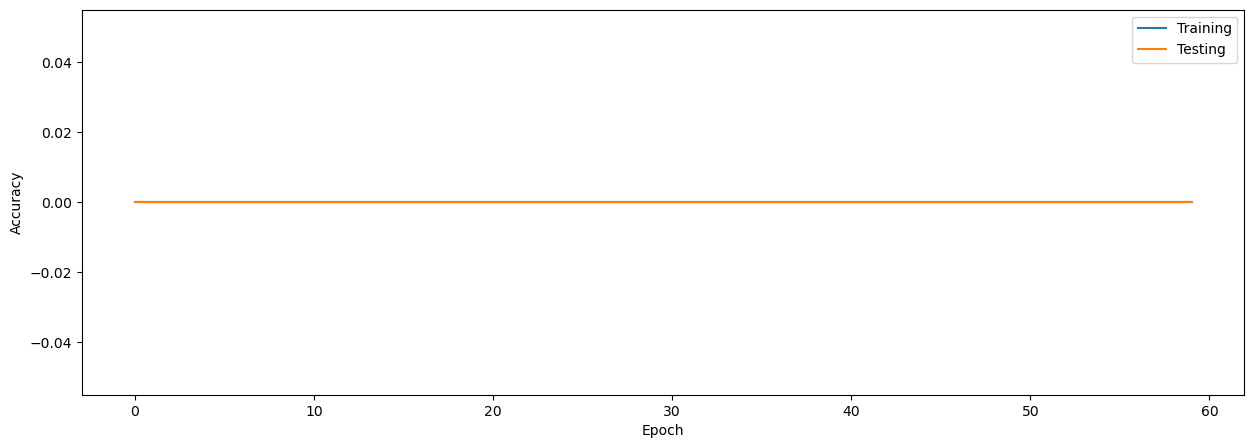

In [22]:
stats.plot(figsize=(15, 5))

In [23]:
# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 3212


# SNN-MLP-Univariate-Sigma-Delta-Network-SDNN-LAVA

In [24]:
#data = read_csv('jordan_pv.csv', parse_dates=['date'],  index_col='date')
data = read_csv('Palestine-PV.csv', parse_dates=['date'],  index_col='date')
# Convert index to datetime
data.index = pd.to_datetime(data.index)
# Sort the DataFrame by the index (date) in ascending order to ensure oldest to newest
data = data.sort_index()

# manually specify column names
# Now select the first column after the index
data = data.iloc[:, 5] 
#print(data.shape)
# summarize first 5 rows
#print(data.head(7))
#print(data.tail(7))
#print(data.describe().T)  
print(data.isnull().sum())
data.info()
#plt.plot(data)
data = data[~np.isnan(data)]
data = data.dropna()
data = data.astype('float64')
# Convert the Series to a numpy array and reshape
data= np.array(data).reshape(-1, 1)
# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
train_size = int(len(data) * 0.90)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]

#creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) 
#and Y is the number of passengers at the next time (t + 1).

def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
seq_size =3 # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.
train_X, train_y = to_sequences(train, seq_size)
test_X, test_y = to_sequences(test, seq_size)
print(train_X.shape, train_y.shape, test_X.shape, test_y .shape)
print(train_X)
# Convert data and labels to PyTorch tensors
train_X=torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X=torch.Tensor(test_X)
test_y = torch.Tensor(test_y)

# Reshape for Conv3d

train_X = train_X.reshape((train_X.shape[0],train_X.shape[1], 1,1,1))
test_X = test_X.reshape((test_X.shape[0],test_X.shape[1], 1,1 ,1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# Hyperparameters
spike_rate = 0.1
temporal_rate = 1

def event_rate_loss(x, max_rate=0.01):
    mean_event_rate = torch.mean(torch.abs(x))
    return F.mse_loss(F.relu(mean_event_rate - max_rate), torch.zeros_like(mean_event_rate))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
train_X = train_X.reshape((train_X.shape[0],   train_X.shape[1],1))
test_X = test_X.reshape((test_X.shape[0],    test_X.shape[1],1))

# Convert data and labels to PyTorch tensors
train_X=torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X=torch.Tensor(test_X)
test_y = torch.Tensor(test_y)

class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        sdnn_params = { # sigma-delta neuron parameters
                'threshold'     : 0.05,    # delta unit threshold
                'tau_grad'      : 0.05,    # delta unit surrogate gradient relaxation parameter
                'scale_grad'    : 1,      # delta unit surrogate gradient scale parameter
                'requires_grad' : True,   # trainable threshold
                'shared_param'  : True,   # layer wise threshold
                'activation'    : F.relu, # activation function
            }
        sdnn_cnn_params = { # conv layer has additional mean only batch norm
                **sdnn_params,                                 # copy all sdnn_params
                'norm' : slayer.neuron.norm.MeanOnlyBatchNorm, # mean only quantized batch normalizaton
            }
        sdnn_dense_params = { # dense layers have additional dropout units enabled
                **sdnn_cnn_params,                        # copy all sdnn_cnn_params
                'dropout' : slayer.neuron.Dropout(p=0.05), # neuron dropout
            }
        self.blocks = torch.nn.ModuleList([
            # delta encoding of the input
            slayer.block.sigma_delta.Input(sdnn_cnn_params),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 3,32),# weight_scale=2, weight_norm=True),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32,32), #weight_scale=2, weight_norm=True),
            # linear readout with sigma decoding of output
            slayer.block.sigma_delta.Output(sdnn_dense_params, 32, 1),# weight_scale=2, weight_norm=True)
        ])

    def forward(self, x):
        count = []
        event_cost = 0
        sparsity_list = []  # Initialize the sparsity list here

        for i, block in enumerate(self.blocks):
            # forward computation is as simple as calling the blocks in a loop
            x = block(x)
            #print("Input shape:", x.shape)
            if hasattr(block, 'neuron'):
                event_cost += event_rate_loss(x)
                
                masked_x = torch.where(x > 0, x, torch.zeros_like(x))

                # Compute the sum of absolute values of this new tensor
                count.append(torch.sum(torch.abs(masked_x)).item())
                #count.append(torch.sum(torch.sum((x[..., 1:]) > 0).to(x.dtype)).item())
                # Before computing sparsity, check if total_elements is greater than zero
                

        return x, event_cost, torch.FloatTensor(count).reshape((1, -1)).to(x.device)
    def grad_flow(self, path):
        # helps monitor the gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]

        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()

        return grad
    
    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))
            batch  =64# batch size
lr     = 0.001# leaerning rate
lam    = 0.01  # lagrangian for event rate loss
epochs =60  # training epochs
steps  = [60, 120, 160] # learning rate reduction milestones
#steps  = [10, 20, 30,40,50,60] # learning rate reduction milestones
trained_folder = 'Trained'
logs_folder = 'Logs'
os.makedirs(trained_folder, exist_ok=True)
os.makedirs(logs_folder   , exist_ok=True)
#device = torch.device('cuda')
device = torch.device('cpu')
# Instantiate Network, Optimizer, Dataset, and Dataloader
net = Network().to(device)
optimizer = torch.optim.RAdam(net.parameters(), lr=lr, weight_decay=1e-5) #CONV and Dense
#optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=1e-5) #CONV and Dense
#optimizer = torch.optim.Adam(net.parameters(), lr=0.001)     #For cuba

print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

training_set = torch.utils.data.TensorDataset(train_X, train_y)
testing_set = torch.utils.data.TensorDataset(test_X, test_y)

train_loader = torch.utils.data.DataLoader(dataset=training_set, batch_size=batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testing_set, batch_size=batch, shuffle=False)

stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(
    net=net,
    error=lambda output  , target: F.mse_loss(output.flatten(), target.flatten()),
    optimizer=optimizer,
    stats=stats,
    count_log=True,
    lam=lam,
    #classifier=slayer.classifier.Rate.predict
)

# Train loop 


for epoch in range(epochs):
    if epoch in steps:
        for param_group in optimizer.param_groups:    
            print('\nLearning rate reduction from', param_group['lr'])
            param_group['lr'] /= 10/3
        
    for i, (input, ground_truth) in enumerate(train_loader): # training loop
        
        assistant.train(input, ground_truth)
        print(f'\r[Epoch {epoch:3d}/{epochs}] {stats}', end='')
    
    for i, (input, ground_truth) in enumerate(test_loader): # testing loop
        
        assistant.test(input, ground_truth)
        print(f'\r[Epoch {epoch:3d}/{epochs}] {stats}', end='')
        
    if epoch%50==49: print() 
    if stats.testing.min_loss:  
        torch.save(net.state_dict(), trained_folder + '/network.pt')
    stats.update()
    stats.save(trained_folder + '/')
    
    # gradient flow monitoring
    net.grad_flow(trained_folder + '/')
    
    # checkpoint saves
    if epoch%10 == 0:
        torch.save({'net': net.state_dict(), 'optimizer': optimizer.state_dict()}, logs_folder + f'/checkpoint{epoch}.pt')            



0
<class 'pandas.core.series.Series'>
DatetimeIndex: 26280 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Series name: Solar Radiation(GHI)
Non-Null Count  Dtype  
--------------  -----  
26280 non-null  float64
dtypes: float64(1)
memory usage: 410.6 KB
(23648, 3) (23648,) (2624, 3) (2624,)
[[0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 ...
 [0.36311787 0.55798479 0.71387833]
 [0.55798479 0.71387833 0.81463878]
 [0.71387833 0.81463878 0.85361217]]
torch.Size([23648, 3, 1, 1, 1]) torch.Size([23648]) torch.Size([2624, 3, 1, 1, 1]) torch.Size([2624])
torch.Size([23648, 3, 1, 1, 1]) torch.Size([23648]) torch.Size([2624, 3, 1, 1, 1]) torch.Size([2624])
torch.Size([23648, 3, 1])
torch.Size([2624, 3, 1])
torch.Size([23648])
torch.Size([2624])
[Epoch  49/60] Train loss =     0.00640 (min =     0.00639)     accuracy = 0.00000 (max = 0.00000)  | Test  loss =     0.00382 (min =     0.00386)     accuracy = 0.00000 (max = 0.00000) 


In [16]:
#  Evaluation: Calculate and Print Unnormalized RMSE and MAE for Testing Set

Test RMSE (Unnormalized): 70.1351
Test MAE (Unnormalized): 33.3882


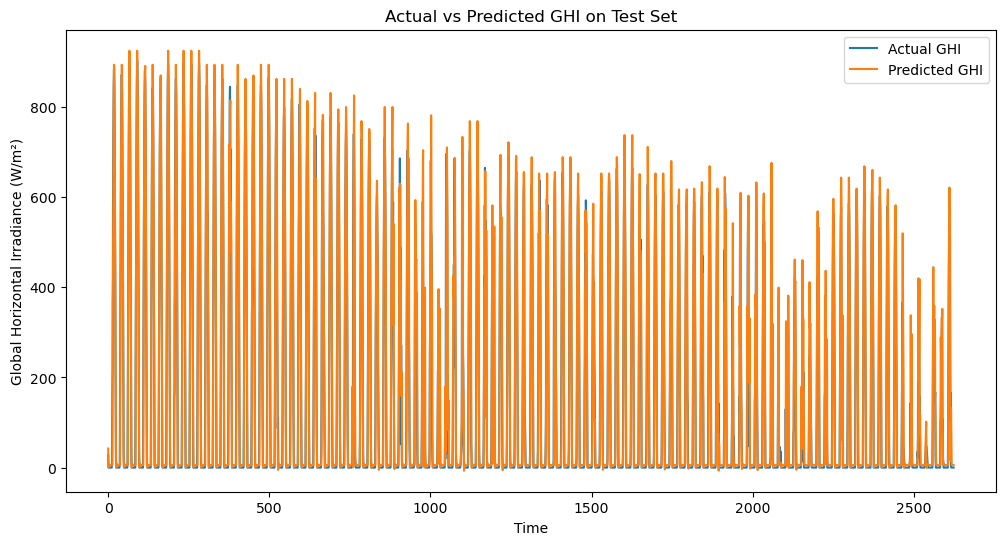

In [25]:
# Evaluation: Calculate and Print Unnormalized RMSE and MAE for Testing Set
# Ensure the model is in evaluation mode
net.eval()

# Make predictions on the test set
with torch.no_grad():
    test_predictions, _, _ = net(test_X.to(device))
    test_predictions = test_predictions.cpu().numpy()

# Inverse transform the predictions and actual values
test_predictions_inv = scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_y_inv = scaler.inverse_transform(test_y.numpy().reshape(-1, 1))

# Calculate RMSE and MAE
test_rmse = np.sqrt(mean_squared_error(test_y_inv, test_predictions_inv))
test_mae = mean_absolute_error(test_y_inv, test_predictions_inv)

print(f"Test RMSE (Unnormalized): {test_rmse:.4f}")
print(f"Test MAE (Unnormalized): {test_mae:.4f}")

# Optionally, plot the predictions vs actual values
plt.figure(figsize=(12,6))
plt.plot(test_y_inv, label='Actual GHI')
plt.plot(test_predictions_inv, label='Predicted GHI')
plt.xlabel('Time')
plt.ylabel('Global Horizontal Irradiance (W/m²)')
plt.title('Actual vs Predicted GHI on Test Set')
plt.legend()
plt.show()

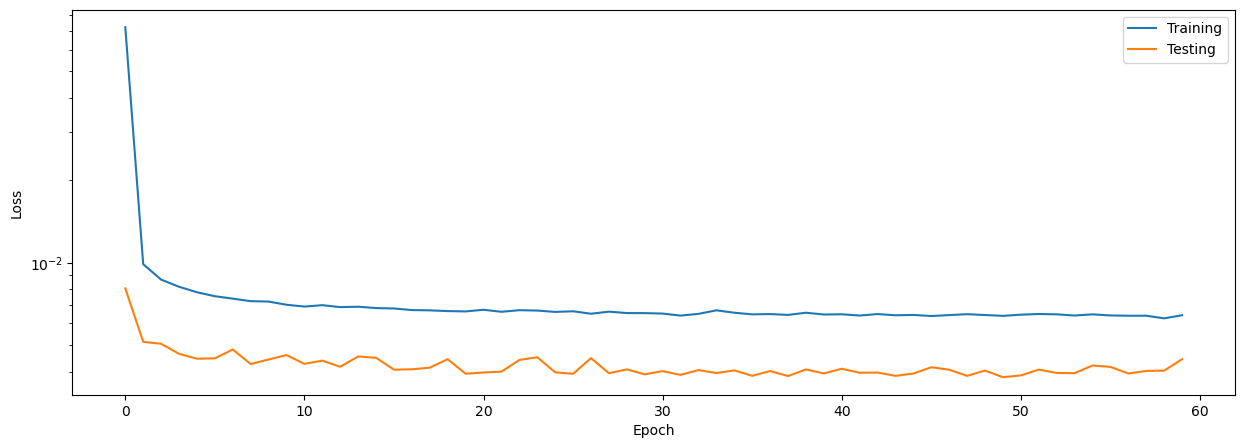

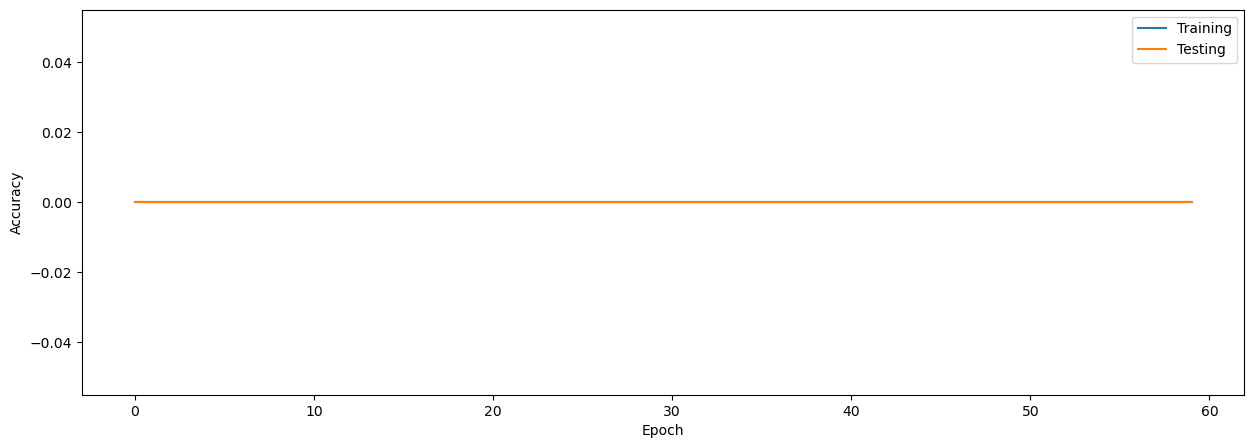

In [26]:
stats.plot(figsize=(15, 5))

In [19]:
# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 1160


# Event statistics on testing dataset

In [14]:
counts = []
for i, (input, ground_truth) in enumerate(test_loader):
    _, count = assistant.test(input, ground_truth)
    #print(count)
    count = (count.flatten()/(input.shape[-1])/input.shape[0]).tolist() # count skips first events
    counts.append(count)
    print('\rEvent count : ' + ', '.join([f'{c:.4f}' for c in count]), f'| {stats.testing}', end='')

counts = np.mean(counts, axis=0)

Event count : 0.2783, 0.8155, 0.8149, 0.0992 | loss =     0.00482 (min =     0.00467)     accuracy = 0.00000 (max = 0.00000) 

In [22]:
import importlib.util
#spec = importlib.util.spec_from_file_location("desired_utils", "D:/Profiles/anaconda/Lib/site-packages/lava-dl/tutorials/lava/lib/dl/slayer/pilotnet/utils.py")
spec = importlib.util.spec_from_file_location("desired_utils", "C:/Users/bahgat.ayasi/AppData/Local/anaconda3/Lib/site-packages/lava-dl/tutorials/lava/lib/dl/slayer/pilotnet/utils.py")
desired_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(desired_utils)
# Now you can use desired_utils as the module
#desired_utils.compare_ops()


# caculayte Model Sparsity , Events and synaptic operations 

In [23]:
#utils.compare_ops(net, counts, mse=stats.testing.min_loss)
desired_utils.compare_ops(net, counts, mse=stats.testing.min_loss)

|-----------------------------------------------------------------------------|
|                         |          SDNN           |           ANN           |
|-----------------------------------------------------------------------------|
|         |     Shape     |  Events  |    Synops    | Activations|    MACs    |
|-----------------------------------------------------------------------------|
| layer-0 | (  1,  1,  3) |     0.46 |              |          3 |            |
| layer-1 | (  1,  1, 32) |     0.76 |        14.74 |         32 |         96 |
| layer-2 | (  1,  1, 32) |     0.57 |        24.47 |         32 |       1024 |
| layer-3 | (  1,  1,  1) |     0.16 |         0.57 |          1 |         32 |
|-----------------------------------------------------------------------------|
|  Total  |               |     1.95 |        39.78 |         68 |       1152 |
|-----------------------------------------------------------------------------|


MSE            : 0.0045357 sq. radians